Statistical Theory - Final Project : Student Alcohol Consumption

Authors: Shilo Avital & Sarel Lieberman


In [27]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    accuracy_score,
    classification_report,
)
from sklearn.linear_model import LogisticRegression

In [28]:
# Plotting style
plt.rcParams.update(
    {
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "legend.fontsize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
    }
)

In [29]:
def load_data():
    math_df = pd.read_csv("data/student-mat.csv")
    por_df = pd.read_csv("data/student-por.csv")
    # concat dataframes vertically
    df = pd.concat([math_df, por_df], axis=0)
    return df

In [30]:
def save_figure(fig, filename: Path):
    """Save and close a matplotlib figure."""
    fig.tight_layout()
    fig.savefig(filename, bbox_inches="tight")
    plt.show()
    plt.close(fig)

In [31]:
Path("figures").mkdir(exist_ok=True)
df_copy = load_data()
fout = open("results_summary.txt", "w", encoding="utf-8")

Q1: Alcohol consumption vs grades
 Pearson r (Walc vs G3) = -0.116,  p = 0.0001784
 ANOVA results:
                sum_sq      df         F    PR(>F)
C(Walc)     223.514612     4.0  3.780943  0.004641
Residual  15355.407802  1039.0       NaN       NaN
 Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.2714  0.912 -1.1356  0.5928  False
     1      3  -0.4537 0.6524 -1.3642  0.4568  False
     1      4  -1.2075 0.0132 -2.2452 -0.1697   True
     1      5  -1.3465 0.0476  -2.684 -0.0089   True
     2      3  -0.1823  0.988  -1.193  0.8283  False
     2      4  -0.9361 0.1553 -2.0627  0.1905  False
     2      5  -1.0751 0.2264 -2.4827  0.3325  False
     3      4  -0.7538 0.3907 -1.9163  0.4087  False
     3      5  -0.8927 0.4354 -2.3292  0.5437  False
     4      5   -0.139 0.9991 -1.6593  1.3813  False
---------------------------------------

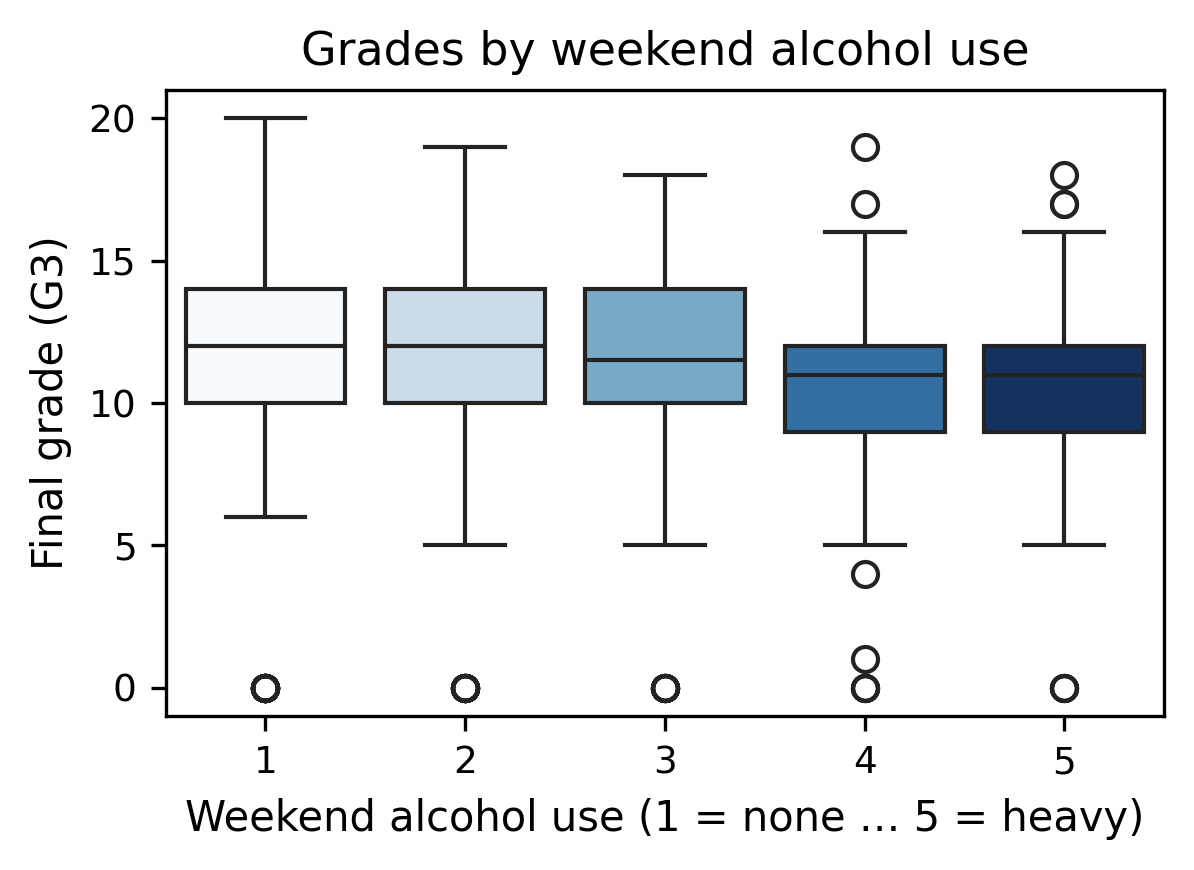

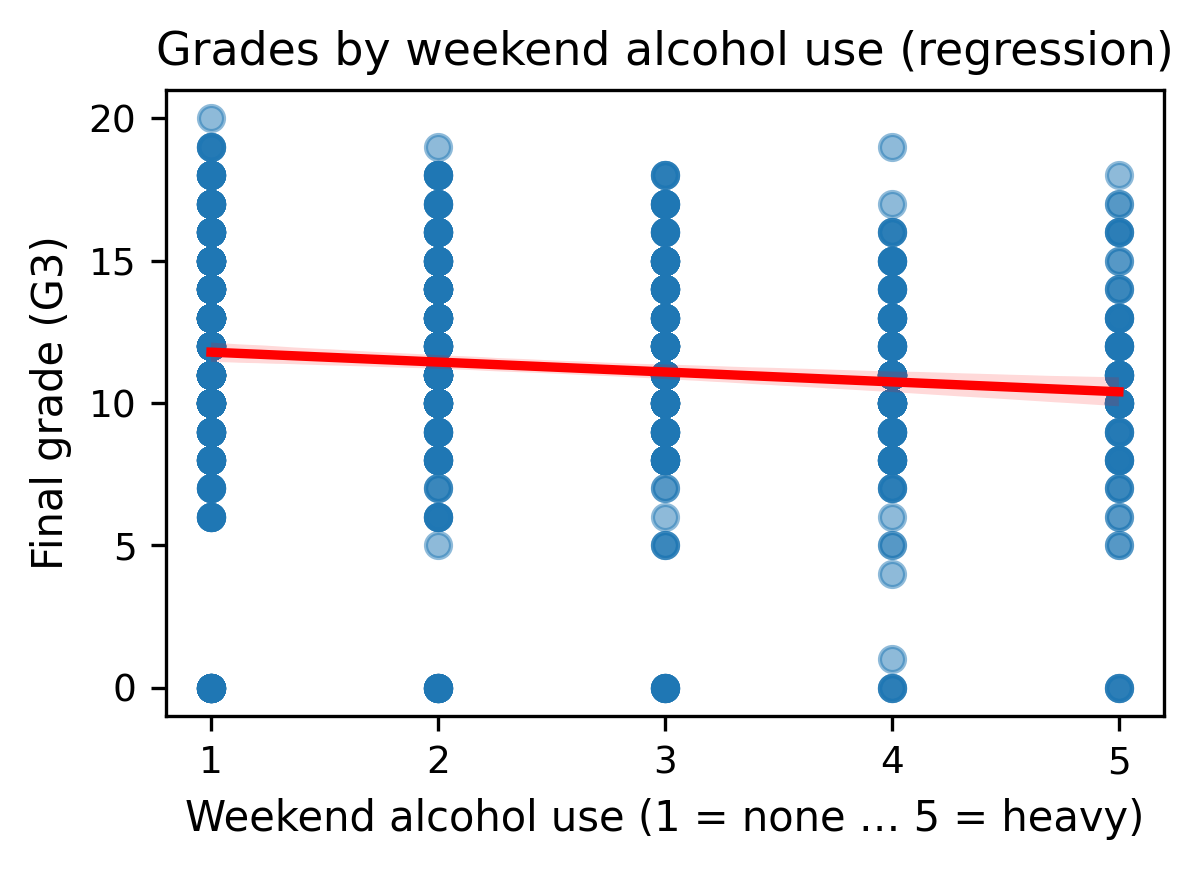

In [32]:
df = df_copy.copy()
msg = "Q1: Alcohol consumption vs grades"
fout.write(f"{msg}\n")
print(msg)

# Pearson correlation
r, p = stats.pearsonr(df["Walc"], df["G3"])
msg = f" Pearson r (Walc vs G3) = {r:.3f},  p = {p:.4g}"
fout.write(msg + "\n")
print(msg)

# Perform ANOVA
model = smf.ols("G3 ~ C(Walc)", data=df).fit()
anova = sm.stats.anova_lm(model, typ=2)
msg = " ANOVA results:\n" + anova.to_string()
fout.write(msg + "\n\n")
print(msg)

# Tukey's HSD post hoc test
tukey = pairwise_tukeyhsd(endog=df["G3"], groups=df["Walc"], alpha=0.05)
msg = " Tukey HSD results:\n" + str(tukey)
fout.write(msg + "\n\n")
print(msg)


df["Walc"] = df["Walc"].astype(int)
frequent_drinkers = df[df["Walc"] > 3]["G3"]
non_frequent_drinkers = df[df["Walc"] <= 3]["G3"]
u_statistic, p_value = stats.mannwhitneyu(
    frequent_drinkers, non_frequent_drinkers, alternative="less"
)
msg = f" Mann-Whitney U test: U-statistic = {u_statistic:.4f}, p-value = {p_value:.6f}"
fout.write(msg + "\n")
print(msg)
if p_value < 0.05:
    msg = "Conclusion: There is a significant difference in G3 between frequent and non-frequent drinkers."
    fout.write(msg + "\n")
    print(msg)
else:
    msg = "Conclusion: No significant difference in G3 between frequent and non-frequent drinkers."
    fout.write(msg + "\n")
    print(msg)


fig, ax = plt.subplots(figsize=(4.2, 3))
sns.boxplot(data=df, x="Walc", y="G3", hue="Walc", palette="Blues", ax=ax, legend=False)
ax.set_xlabel("Weekend alcohol use (1 = none … 5 = heavy)")
ax.set_ylabel("Final grade (G3)")
ax.set_title("Grades by weekend alcohol use")
save_figure(fig, Path("figures/Q1_G3_Walc_boxplot.png"))

# plot a scatter plot with regression line for all the data
fig, ax = plt.subplots(figsize=(4.2, 3))
sns.regplot(
    data=df,
    x="Walc",
    y="G3",
    ax=ax,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
ax.set_xlabel("Weekend alcohol use (1 = none … 5 = heavy)")
ax.set_ylabel("Final grade (G3)")
ax.set_title("Grades by weekend alcohol use (regression)")
save_figure(fig, Path("figures/Q1_G3_Walc_regression.png"))

msg = f'{"-" * 80}'
fout.write(msg + "\n\n")
print()

In [33]:
df = df_copy.copy()
msg = "Q2: Joint test of predictors on weekend alcohol use"
fout.write(f"{msg}\n")
print(msg)

df["Pstatus"] = df["Pstatus"].map({"T": 1, "A": 0})
df["famsup"] = df["famsup"].map({"yes": 1, "no": 0})
df["romantic"] = df["romantic"].map({"yes": 1, "no": 0})

# Define predictors and outcome
X = df[["Fedu", "Medu", "Pstatus", "famsup", "romantic"]]
y = df["Walc"]

# 2. Fit the full model
mod = OrderedModel(endog=y, exog=X, distr="logit")
res = mod.fit(method="bfgs", disp=False)

# 3. Build R for a joint test β1=…=β5=0
k_exog = X.shape[1]  # = 5
p_total = len(res.params)  # = 5 slopes + 4 thresholds = 9

# Initialize R as zeros (5 constraints × 9 params)
R = np.zeros((k_exog, p_total))

# Place 1’s on the diagonal for the slope parameters
for i in range(k_exog):
    R[i, i] = 1

# 4. Run the Wald test
wald_res = res.wald_test(R, scalar=True)

# Extract and print results
stat = float(wald_res.statistic)  # χ²
df_num = int(wald_res.df_denom)  # should be 5
pval = float(wald_res.pvalue)

msg = f"\nWald joint test of β1=…=β5=0\n  χ²({df_num}) = {stat:.3f}, p = {pval:.4f}"
fout.write(msg + "\n")
print(msg)
if pval < 0.05:
    msg = "→ Reject H₀: predictors jointly explain G3."
    fout.write(msg + "\n")
    print(msg)
else:
    msg = "→ Fail to reject H₀: no joint effect on G3 detected."
    fout.write(msg + "\n")
    print(msg)
msg = f'{"-" * 80}'
fout.write(msg + "\n\n")
print()

Q2: Joint test of predictors on weekend alcohol use

Wald joint test of β1=…=β5=0
  χ²(5) = 11.789, p = 0.0378
→ Reject H₀: predictors jointly explain G3.



Q3: Kruskal-Wallis test and Pearson Correlation for predictors on G3 (Heavy Drinkers)
Fedu         | Kruskal-Wallis: stat=12.24, p=0.0066 | Pearson r=0.21, p=0.0025
Medu         | Kruskal-Wallis: stat=14.42, p=0.0061 | Pearson r=0.20, p=0.0028
Pstatus      | Kruskal-Wallis: stat=1.96, p=0.1619 | Pearson r=-0.08, p=0.2296
famsup       | Kruskal-Wallis: stat=0.31, p=0.5808 | Pearson r=-0.03, p=0.6213
romantic     | Kruskal-Wallis: stat=1.13, p=0.2880 | Pearson r=-0.12, p=0.0785
studytime    | Kruskal-Wallis: stat=0.19, p=0.9800 | Pearson r=0.01, p=0.8702
failures     | Kruskal-Wallis: stat=47.38, p=0.0000 | Pearson r=-0.47, p=0.0000
schoolsup    | Kruskal-Wallis: stat=1.45, p=0.2285 | Pearson r=-0.06, p=0.4010
higher       | Kruskal-Wallis: stat=22.92, p=0.0000 | Pearson r=0.33, p=0.0000
goout        | Kruskal-Wallis: stat=6.62, p=0.1571 | Pearson r=-0.13, p=0.0512
absences     | Kruskal-Wallis: stat=17.45, p=0.7379 | Pearson r=-0.04, p=0.5795


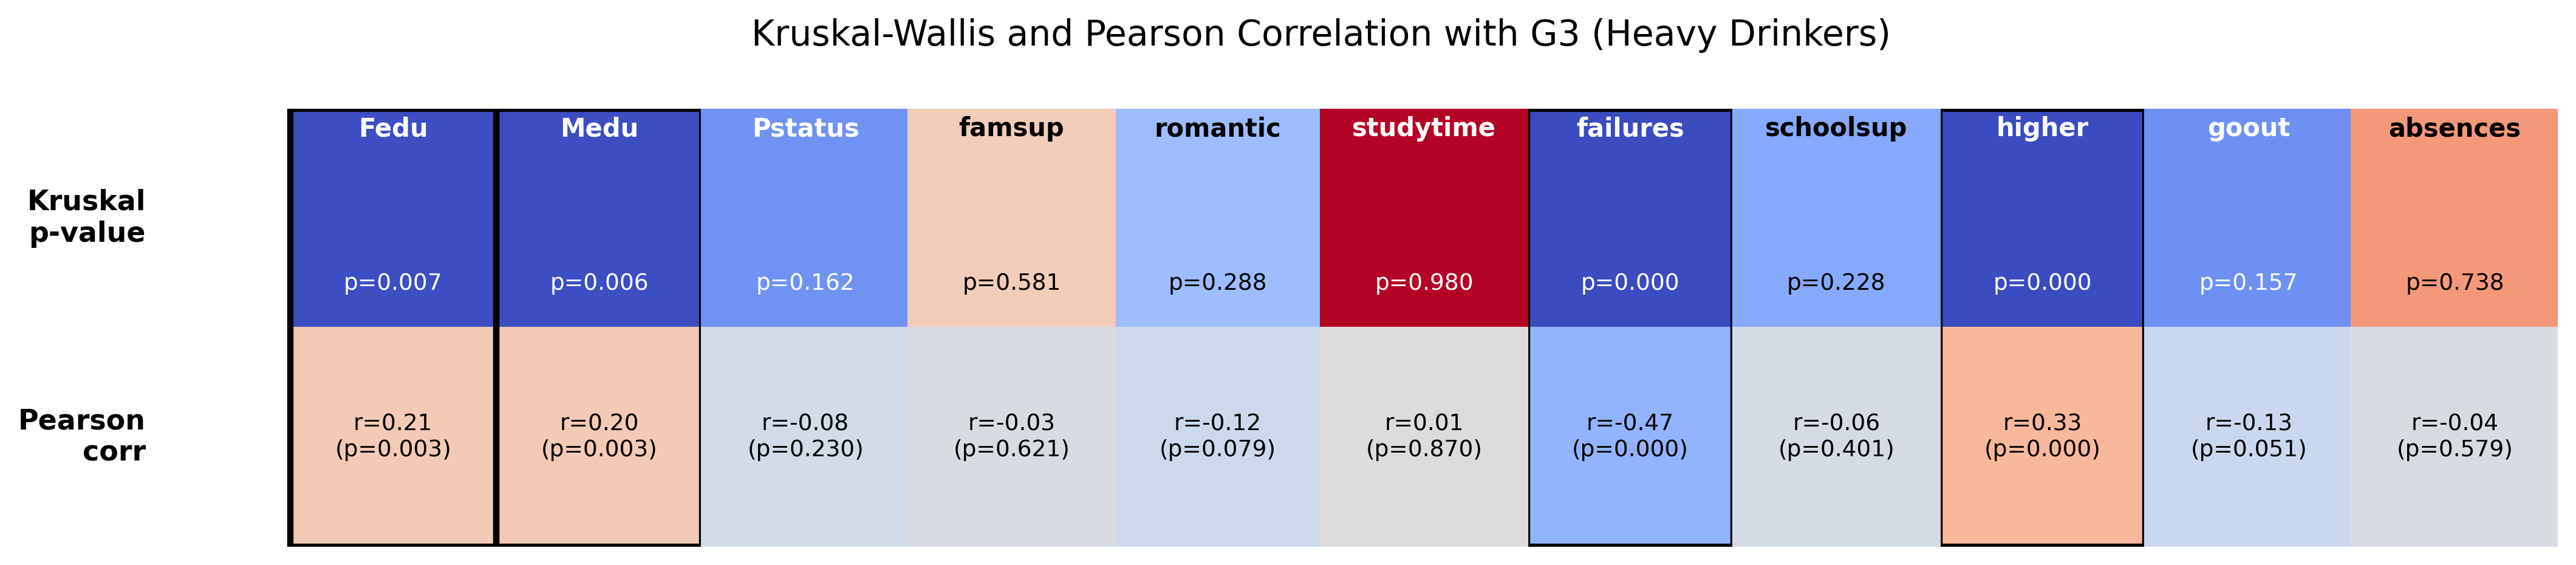

Significant predictors (p < 0.05 for both tests):

  failures: Kruskal p=0.000, Pearson r=-0.47
  higher: Kruskal p=0.000, Pearson r=0.33
  Medu: Kruskal p=0.006, Pearson r=0.20
  Fedu: Kruskal p=0.007, Pearson r=0.21



In [74]:
df = df_copy.copy()
msg = "Q3: Kruskal-Wallis test and Pearson Correlation for predictors on G3 (Heavy Drinkers)"
fout.write(f"{msg}\n")
print(msg)

# Encode categorical variables
df["Pstatus"] = df["Pstatus"].map({"T": 1, "A": 0})
df["famsup"] = df["famsup"].map({"yes": 1, "no": 0})
df["romantic"] = df["romantic"].map({"yes": 1, "no": 0})
df["schoolsup"] = df["schoolsup"].map({"yes": 1, "no": 0})
df["higher"] = df["higher"].map({"yes": 1, "no": 0})

# Filter for heavy drinkers
df = df[df["Walc"] >= 4]

predictors = [
    "Fedu",
    "Medu",
    "Pstatus",
    "famsup",
    "romantic",
    "studytime",
    "failures",
    "schoolsup",
    "higher",
    "goout",
    "absences",
]

# Collect Kruskal and Pearson results
results = []
for col in predictors:
    # Kruskal-Wallis test
    groups = [df[df[col] == val]["G3"] for val in df[col].dropna().unique()]
    kw_stat, kw_p = kruskal(*groups)

    # Pearson correlation
    r, p = stats.pearsonr(df["G3"], df[col])

    results.append(
        {
            "Predictor": col,
            "Kruskal_stat": kw_stat,
            "Kruskal_p": kw_p,
            "Pearson_r": r,
            "Pearson_p": p,
        }
    )

    msg = f"{col:<12s} | Kruskal-Wallis: stat={kw_stat:.2f}, p={kw_p:.4f} | Pearson r={r:.2f}, p={p:.4f}"
    fout.write(msg + "\n")
    print(msg)

# Convert to DataFrame and sort by Kruskal p-value
res_df = pd.DataFrame(results)
res_df.sort_values("Kruskal_p", inplace=True)

# Save summary
msg = f"\n{'-' * 80}\nCombined Kruskal & Pearson results:\n"
fout.write(msg + "\n")
fout.write(res_df.to_string(index=False) + "\n\n")

# -----------------------------------
# Plot: Dual-row heatmap
# -----------------------------------

# Normalize for color mapping (Kruskal p-values)
norm = plt.Normalize(res_df["Kruskal_p"].min(), res_df["Kruskal_p"].max())
colors = plt.cm.coolwarm(norm(res_df["Kruskal_p"]))


def get_contrasting_font_color(rgba_color):
    r, g, b = rgba_color[:3]
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return "black" if luminance > 0.6 else "white"


fig, ax = plt.subplots(figsize=(len(res_df) * 1.3, 3.2))

# --- Plot each column ---
for i, row in res_df.iterrows():
    pred = row["Predictor"]
    kw_p = row["Kruskal_p"]
    r = row["Pearson_r"]
    pearson_p = row["Pearson_p"]

    # --- Kruskal row (top) ---
    kw_color = plt.cm.coolwarm(norm(kw_p))
    ax.add_patch(plt.Rectangle((i, 1), 1, 1, color=kw_color))
    text_color_kw = get_contrasting_font_color(kw_color)
    ax.text(i + 0.5, 1.25, f"p={kw_p:.3f}", ha="center", va="top", fontsize=9, color=text_color_kw)

    # --- Pearson row (bottom) ---
    pearson_color = plt.cm.coolwarm((r + 1) / 2)
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=pearson_color))
    text_color_r = get_contrasting_font_color(pearson_color)
    ax.text(
        i + 0.5,
        0.5,
        f"r={r:.2f}\n(p={pearson_p:.3f})",
        ha="center",
        va="center",
        fontsize=9,
        color=text_color_r,
    )
    ax.text(
        i + 0.5,
        1.85,
        pred,
        ha="center",
        va="bottom",
        fontsize=10,
        weight="bold",
        color=get_contrasting_font_color(kw_color),
    )

    # --- Highlight box if both p-values < 0.05 ---
    if kw_p < 0.05 and pearson_p < 0.05:
        ax.add_patch(
            plt.Rectangle((i, 0), 1, 2, fill=False, edgecolor="black", linewidth=2.5)
        )

# --- Row labels ---
ax.text(
    -0.7, 1.5, "Kruskal\np-value", ha="right", va="center", fontsize=11, weight="bold"
)
ax.text(-0.7, 0.5, "Pearson\ncorr", ha="right", va="center", fontsize=11, weight="bold")

# --- Formatting ---
ax.set_xlim(-1, len(res_df))
ax.set_ylim(0, 2)
ax.axis("off")

# # --- Colorbars ---
# sm1 = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
# sm1.set_array([])
# cbar1 = fig.colorbar(sm1, ax=ax, orientation="horizontal", fraction=0.08, pad=0.1)


# sm2 = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(-1, 1))
# sm2.set_array([])
# cbar2 = fig.colorbar(sm2, ax=ax, orientation="horizontal", fraction=0.08, pad=0.2)

plt.title(
    "Kruskal-Wallis and Pearson Correlation with G3 (Heavy Drinkers)",
    fontsize=14,
    pad=25,
)

# Save figure
save_figure(fig, Path("figures/Q3_Kruskal_and_Correlation.png"))

# print what predictors were significant
significant_predictors = res_df[(res_df["Kruskal_p"] < 0.05) & (res_df["Pearson_p"] < 0.05)]
if not significant_predictors.empty:
    msg = "Significant predictors (p < 0.05 for both tests):\n"
    fout.write(msg + "\n")
    print(msg)
    for _, row in significant_predictors.iterrows():
        msg = f"  {row['Predictor']}: Kruskal p={row['Kruskal_p']:.3f}, Pearson r={row['Pearson_r']:.2f}"
        fout.write(msg + "\n")
        print(msg)
else:
    msg = "No predictors were significant (p < 0.05) for both tests."
    fout.write(msg + "\n")
    print(msg)

# Final separator
fout.write(f"{'-'*80}\n\n")
print()

Q4: Predicting student failure using logistic regression

AUC: 0.846
Accuracy: 0.770
Confusion matrix:
[[118  14]
 [ 34  43]]

Classification report:
              precision    recall  f1-score   support

           0      0.776     0.894     0.831       132
           1      0.754     0.558     0.642        77

    accuracy                          0.770       209
   macro avg      0.765     0.726     0.736       209
weighted avg      0.768     0.770     0.761       209



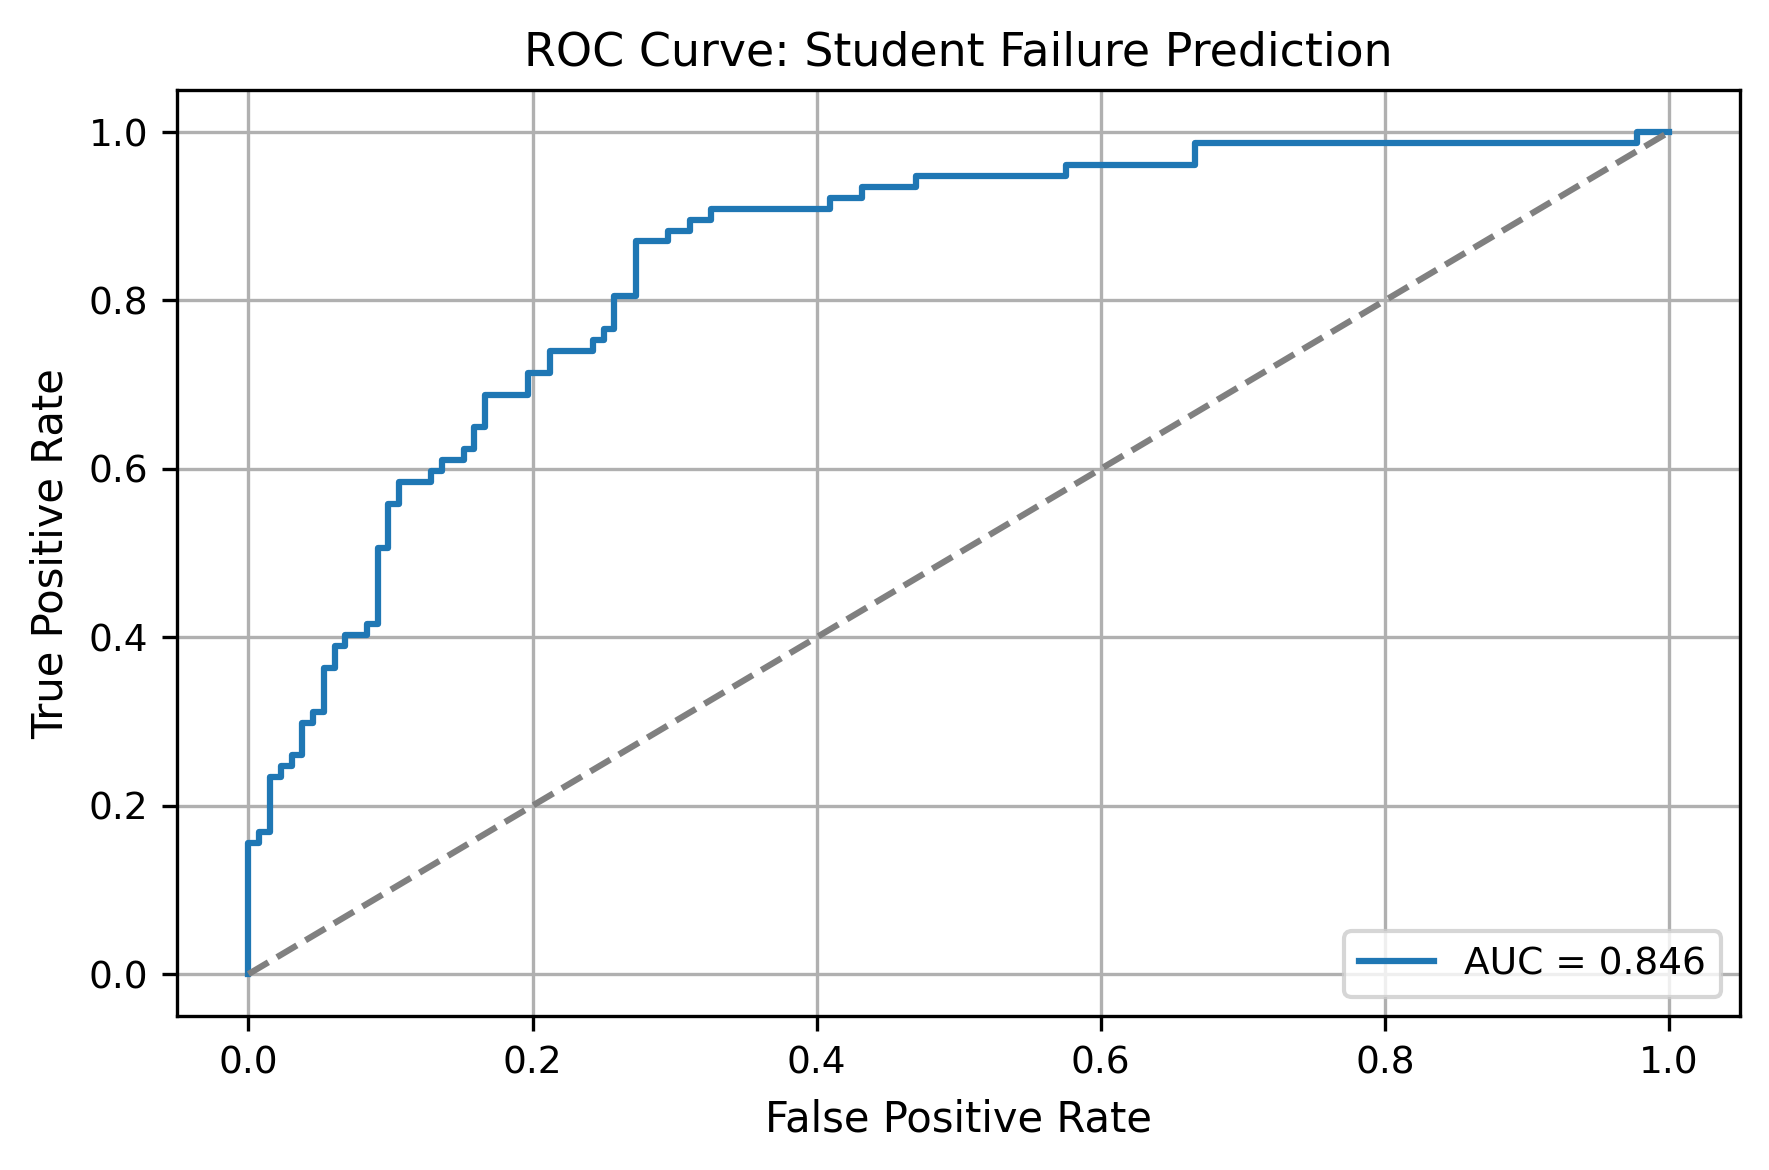

In [35]:
df = df_copy.copy()

msg = "Q4: Predicting student failure using logistic regression"
fout.write(f"{msg}\n")
print(msg)


# 2. Feature engineering
binary_map = {"yes": 1, "no": 0}
for col in ["famsup", "schoolsup", "romantic", "higher"]:
    df[col] = df[col].map(binary_map)

# Predictors and target
PREDICTORS = [
    "Walc",
    "absences",
    "studytime",
    "failures",
    "famsup",
    "schoolsup",
    "health",
    "romantic",
    "higher",
    "goout",
    "Fedu",
    "Medu",
]
X = df[PREDICTORS]
y = (df["G3"] < 11).astype(int)  # 1=fail, 0=pass

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=269, stratify=y
)

# 4. Pipeline: scale + logistic regression
pipe = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=10000, solver="lbfgs")
)
pipe.fit(X_train, y_train)

# 5. Predictions & metrics
y_prob = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

msg = (
    f"\nAUC: {auc:.3f}\n"
    f"Accuracy: {acc:.3f}\n"
    f"Confusion matrix:\n{cm}\n\n"
    f"Classification report:\n{report}"
)
fout.write(msg)
print(msg)


# 6. Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Student Failure Prediction")
plt.legend(loc="lower right")
plt.grid(True)
save_figure(plt.gcf(), Path("figures/Q4_ROC_curve.png"))